# AI-based OCR Benchmark Notebook

This notebook benchmarks **AI-based OCR models** on scanned PDF documents/images in Spanish.
It excludes traditional OCR engines like Tesseract that require external installations.

In [1]:
%pip install --upgrade pip
%pip install --upgrade jupyter
%pip install --upgrade ipywidgets
%pip install --upgrade ipykernel

# Install necessary packages
%pip install easyocr transformers torch pdf2image pillow jiwer paddleocr hf_xet paddlepaddle python-doctr
# pdf reading
%pip install PyMuPDF

# Data analysis and visualization
%pip install pandas
%pip install matplotlib
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https:/

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image, ImageOps
import easyocr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
from jiwer import wer, cer
from paddleocr import PaddleOCR
import fitz  # PyMuPDF
from doctr.models import ocr_predictor

## 1 Configuration

In [3]:
PDF_FOLDER = './instructions'  # Folder containing PDF files
OUTPUT_FOLDER = 'results'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [4]:
# 1. EasyOCR 
import easyocr
easyocr_reader = easyocr.Reader(['es', 'en'])  # Spanish and English

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [5]:
# 3. PaddleOCR
from paddleocr import PaddleOCR

# Initialize with better settings for Spanish/Latin text
paddleocr_model = PaddleOCR(
    lang='es',  # Use 'latin' for better Spanish support
    det_db_thresh=0.3,  # Lower threshold for better text detection
    det_db_box_thresh=0.5,
    rec_batch_num=6,
)


C:\Users\sji\AppData\Local\Temp\ipykernel_24884\1981705559.py:5: DeprecationWarning: The parameter `det_db_thresh` has been deprecated and will be removed in the future. Please use `text_det_thresh` instead.
  paddleocr_model = PaddleOCR(
C:\Users\sji\AppData\Local\Temp\ipykernel_24884\1981705559.py:5: DeprecationWarning: The parameter `det_db_box_thresh` has been deprecated and will be removed in the future. Please use `text_det_box_thresh` instead.
  paddleocr_model = PaddleOCR(
C:\Users\sji\AppData\Local\Temp\ipykernel_24884\1981705559.py:5: DeprecationWarning: The parameter `rec_batch_num` has been deprecated and will be removed in the future. Please use `text_recognition_batch_size` instead.
  paddleocr_model = PaddleOCR(
c:\Users\sji\Desktop\MastersThesis\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github

In [6]:
# doctr
doctr_model = ocr_predictor(det_arch="db_resnet50", reco_arch="sar_resnet31", pretrained=True)

## 2 Helper Functions

In [7]:
from typing import List, Optional

def show_page(img: Image.Image, text: str,  scale: float = 0.15):
    """
    Displays a smaller version of the image with text as a footer.
    """
    # Compute plot size based on image dimensions (but without resizing the image)
    w, h = img.size
    figsize = (w * scale / 100, h * scale / 100)  # convert pixels to inches approx

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.axis("off")


    # Add OCR text below the image (footer)
    plt.figtext(0.5, 0.02, text.strip(), wrap=True, ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

def pdf_to_images(pdf_path: str, dpi: int = 300, pages: List[int] = None) -> List[Image.Image]:
    """Render a PDF into a list of PIL Images using PyMuPDF or pdf2image."""
    images = []
    if fitz is not None:
        doc = fitz.open(pdf_path)
        page_indices = pages if pages is not None else list(range(len(doc)))
        for i in page_indices:
            page = doc.load_page(i)
            mat = fitz.Matrix(dpi/72.0, dpi/72.0)
            pix = page.get_pixmap(matrix=mat, alpha=False)
            img = Image.frombytes('RGB', [pix.width, pix.height], pix.samples)
            images.append(img)
        doc.close()
    elif convert_from_path is not None:
        if pages is None:
            images = convert_from_path(pdf_path, dpi=dpi)
        else:
            # pdf2image supports first_page/last_page; render a slice if contiguous
            images = [convert_from_path(pdf_path, dpi=dpi)[i] for i in pages]
    else:
        raise RuntimeError('Install PyMuPDF or pdf2image to convert PDFs.')
    return images

def pdf_extract_text(pdf_path, page_num) -> str:
    """
    Extracts text from a specific PDF page in proper reading order.
    """
    doc = fitz.open(pdf_path)
    
    if page_num < 1 or page_num > len(doc):
        return ""
    
    page = doc[page_num - 1]
    blocks = page.get_text("blocks")  # returns list of (x0, y0, x1, y1, "text", block_no, block_type)
    
    # Sort blocks top-to-bottom, left-to-right
    blocks_sorted = sorted(blocks, key=lambda b: (b[1], b[0]))  # y0, then x0
    
    text = " ".join([b[4].replace('\n', ' ').strip() for b in blocks_sorted])
    return text

def evaluate_text(reference, prediction):
    return {'WER': wer(reference, prediction), 'CER': cer(reference, prediction)}

## 3 Model wrapers

In [8]:
def ocr_easyocr(img, image_array):
    result = easyocr_reader.readtext(image_array)
    res = ' '.join([r[1] for r in result])    
    return res

In [9]:
def ocr_paddle(img, image_array):
    """
    PaddleOCR function
    """
    
    result = paddleocr_model.predict(image_array)
    # Extract text from result
    text_list = []
    # breakpoint()
    items = []
    for item in result:
        boxes = item.json["res"]["rec_boxes"]
        texts = item.json["res"]["rec_texts"]        
        for box, text in zip(boxes, texts):
            x1, y1, _, _ = box
            items.append((x1, y1, text))
    
    # skip ordering, no diff
    # line_tolerance=40
    # Sort top-to-bottom (with tolerance), then left-to-right
    # items.sort(key=lambda t: (round(t[1] / line_tolerance), t[0]))

    # Extract ordered text
    ordered_texts = [t[2] for t in items]
    res = " ".join(ordered_texts)    
    
    return res

In [10]:
def doctr_blocks_to_text(doctr_result):
    """
    Convierte la salida estructurada de DocTR en texto plano preservando el orden de lectura.
    Estructura: Document -> pages -> blocks -> lines -> words
    """
    out_lines = []
    for page in doctr_result.pages:
        for block in page.blocks:
            for line in block.lines:
                out_lines.append(" ".join([w.value for w in line.words]))
        out_lines.append("")  # separador de párrafos
    return " ".join([l for l in out_lines if l is not None]).strip()

def ocr_doctr(img, image_array):
    doc = [image_array]
    result = doctr_model(doc)  # inferencia
    text = doctr_blocks_to_text(result)    
    return text

## 4 Run AI OCR Benchmark

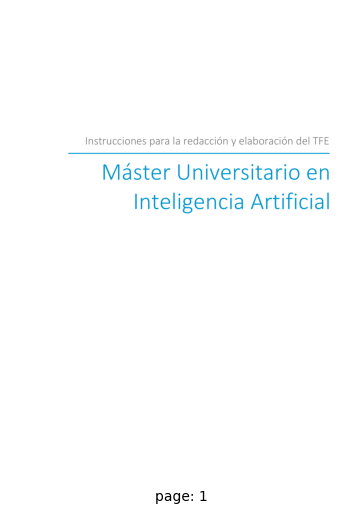

ref:  Instrucciones para la redacción y elaboración del TFE Máster Universitario en Inteligencia Artificial


c:\Users\sji\Desktop\MastersThesis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


easy_text: Instrucciones para la redacción y elaboración del TFE Máster Universitario en Inteligencia Artificial
doctr_text: Instrucciones para la redaccion y elaboracion del TFE Master Universitario en Inteligencia Artificial
paddle_text: Instrucciones para la redacción y elaboración del TFE Máster Universitario en Artificial Inteligencia


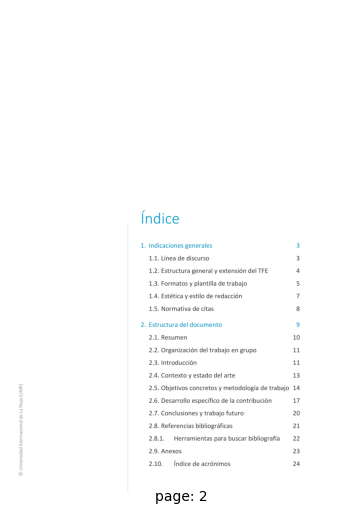

ref:  Índice 1. Indicaciones generales  3 1.1. Línea de discurso  3 1.2. Estructura general y extensión del TFE  4 1.3. Formatos y plantilla de trabajo  5 1.4. Estética y estilo de redacción  7 1.5. Normativa de citas  8 2. Estructura del documento  9 2.1. Resumen  10 2.2. Organización del trabajo en grupo  11 2.3. Introducción  11 2.4. Contexto y estado del arte  13 © Universidad Internacional de La Rioja (UNIR) 2.5. Objetivos concretos y metodología de trabajo 14 2.6. Desarrollo específico de la contribución  17 2.7. Conclusiones y trabajo futuro  20 2.8. Referencias bibliográficas  21 2.8.1.  Herramientas para buscar bibliografía  22 2.9. Anexos  23 2.10.  Índice de acrónimos  24  
easy_text: Indice 1. Indicaciones generales 3 1.1. Línea de discurso 3 1.2. Estructura general y extensión del TFE 1.3. Formatos y plantilla de trabajo ; 1.4. Estética y estilo de redacción 1.5. Normativa de citas 8 2. Estructura del documento 9 2.1. Resumen 10 2.2. Organización del trabajo en grupo 11 2.

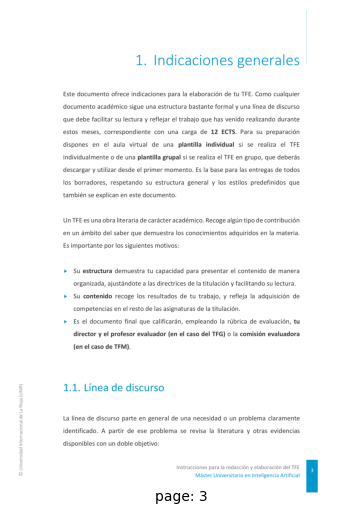

ref: 1. Indicaciones generales Este documento ofrece indicaciones para la elaboración de tu TFE. Como cualquier documento académico sigue una estructura bastante formal y una línea de discurso que debe facilitar su lectura y reflejar el trabajo que has venido realizando durante estos meses, correspondiente con una carga de 12 ECTS. Para su preparación dispones en el aula virtual de una plantilla individual si se realiza el TFE individualmente o de una plantilla grupal si se realiza el TFE en grupo, que deberás descargar y utilizar desde el primer momento. Es la base para las entregas de todos los borradores, respetando su estructura general y los estilos predefinidos que también se explican en este documento.  Un TFE es una obra literaria de carácter académico. Recoge algún tipo de contribución en un ámbito del saber que demuestra los conocimientos adquiridos en la materia. Es importante por los siguientes motivos:   Su estructura demuestra tu capacidad para presentar el contenido de 

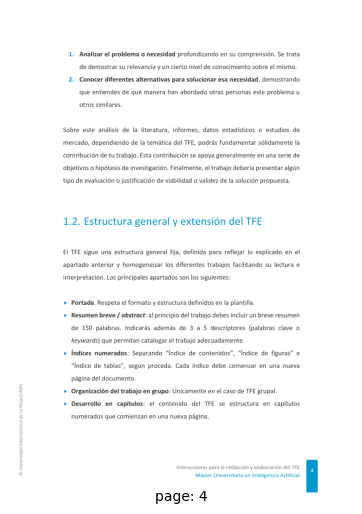

ref: 1. Analizar el problema o necesidad profundizando en su comprensión. Se trata de demostrar su relevancia y un cierto nivel de conocimiento sobre el mismo. 2. Conocer diferentes alternativas para solucionar esa necesidad, demostrando que entiendes de qué manera han abordado otras personas este problema u otros similares.  Sobre este análisis de la literatura, informes, datos estadísticos o estudios de mercado, dependiendo de la temática del TFE, podrás fundamentar sólidamente la contribución de tu trabajo. Esta contribución se apoya generalmente en una serie de objetivos o hipótesis de investigación. Finalmente, el trabajo debería presentar algún tipo de evaluación o justificación de viabilidad o validez de la solución propuesta.  1.2. Estructura general y extensión del TFE  El TFE sigue una estructura general fija, definida para reflejar lo explicado en el apartado anterior y homogeneizar los diferentes trabajos facilitando su lectura e interpretación. Los principales apartados so

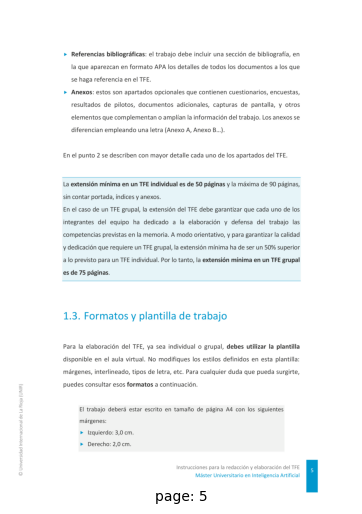

ref:  Referencias bibliográficas: el trabajo debe incluir una sección de bibliografía, en la que aparezcan en formato APA los detalles de todos los documentos a los que se haga referencia en el TFE.  Anexos: estos son apartados opcionales que contienen cuestionarios, encuestas, resultados de pilotos, documentos adicionales, capturas de pantalla, y otros elementos que complementan o amplían la información del trabajo. Los anexos se diferencian empleando una letra (Anexo A, Anexo B…).  En el punto 2 se describen con mayor detalle cada uno de los apartados del TFE.  La extensión mínima en un TFE individual es de 50 páginas y la máxima de 90 páginas, sin contar portada, índices y anexos. En el caso de un TFE grupal, la extensión del TFE debe garantizar que cada uno de los integrantes del equipo ha dedicado a la elaboración y defensa del trabajo las competencias previstas en la memoria. A modo orientativo, y para garantizar la calidad y dedicación que requiere un TFE grupal, la extensión 

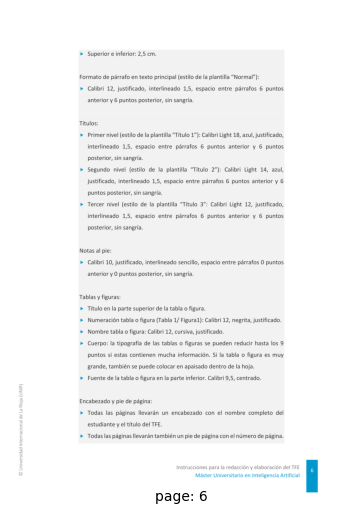

ref:  Superior e inferior: 2,5 cm.  Formato de párrafo en texto principal (estilo de la plantilla “Normal”):  Calibri 12, justificado, interlineado 1,5, espacio entre párrafos 6 puntos anterior y 6 puntos posterior, sin sangría.  Títulos:  Primer nivel (estilo de la plantilla “Título 1”): Calibri Light 18, azul, justificado, interlineado 1,5, espacio entre párrafos 6 puntos anterior y 6 puntos posterior, sin sangría.  Segundo nivel (estilo de la plantilla “Título 2”): Calibri Light 14, azul, justificado, interlineado 1,5, espacio entre párrafos 6 puntos anterior y 6 puntos posterior, sin sangría.  Tercer nivel (estilo de la plantilla “Título 3”: Calibri Light 12, justificado, interlineado 1,5, espacio entre párrafos 6 puntos anterior y 6 puntos posterior, sin sangría.  Notas al pie:  Calibri 10, justificado, interlineado sencillo, espacio entre párrafos 0 puntos anterior y 0 puntos posterior, sin sangría.  Tablas y figuras:  Título en la parte superior de la tabla o figura.  Nu

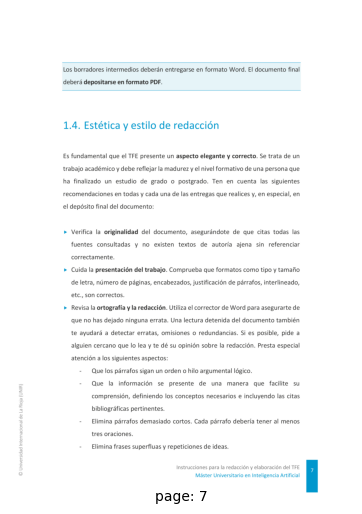

ref:  Los borradores intermedios deberán entregarse en formato Word. El documento final deberá depositarse en formato PDF.   1.4. Estética y estilo de redacción  Es fundamental que el TFE presente un aspecto elegante y correcto. Se trata de un trabajo académico y debe reflejar la madurez y el nivel formativo de una persona que ha finalizado un estudio de grado o postgrado. Ten en cuenta las siguientes recomendaciones en todas y cada una de las entregas que realices y, en especial, en el depósito final del documento:   Verifica la originalidad del documento, asegurándote de que citas todas las fuentes consultadas y no existen textos de autoría ajena sin referenciar correctamente.  Cuida la presentación del trabajo. Comprueba que formatos como tipo y tamaño de letra, número de páginas, encabezados, justificación de párrafos, interlineado, etc., son correctos.  Revisa la ortografía y la redacción. Utiliza el corrector de Word para asegurarte de que no has dejado ninguna errata. Una lec

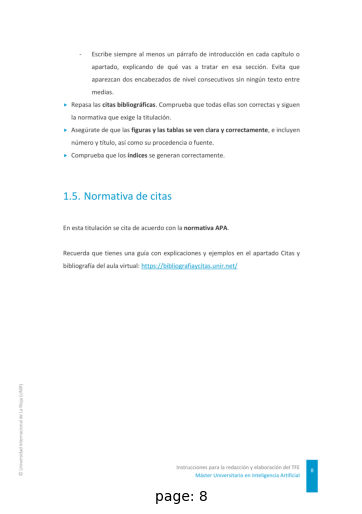

ref: -  Escribe siempre al menos un párrafo de introducción en cada capítulo o apartado, explicando de qué vas a tratar en esa sección. Evita que aparezcan dos encabezados de nivel consecutivos sin ningún texto entre medias.  Repasa las citas bibliográficas. Comprueba que todas ellas son correctas y siguen la normativa que exige la titulación.  Asegúrate de que las figuras y las tablas se ven clara y correctamente, e incluyen número y título, así como su procedencia o fuente.  Comprueba que los índices se generan correctamente.  1.5. Normativa de citas  En esta titulación se cita de acuerdo con la normativa APA.  Recuerda que tienes una guía con explicaciones y ejemplos en el apartado Citas y bibliografía del aula virtual: https://bibliografiaycitas.unir.net/  © Universidad Internacional de La Rioja (UNIR) Instrucciones para la redacción y elaboración del TFE 8 Máster Universitario en Inteligencia Artificial
easy_text: Escribe siempre al menos un párrafo de introducción en cada capí

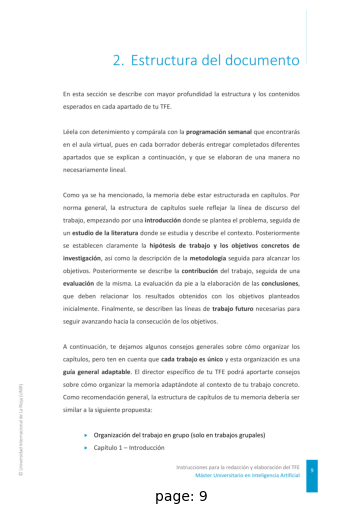

ref: 2. Estructura del documento En esta sección se describe con mayor profundidad la estructura y los contenidos esperados en cada apartado de tu TFE.  Léela con detenimiento y compárala con la programación semanal que encontrarás en el aula virtual, pues en cada borrador deberás entregar completados diferentes apartados que se explican a continuación, y que se elaboran de una manera no necesariamente lineal.  Como ya se ha mencionado, la memoria debe estar estructurada en capítulos. Por norma general, la estructura de capítulos suele reflejar la línea de discurso del trabajo, empezando por una introducción donde se plantea el problema, seguida de un estudio de la literatura donde se estudia y describe el contexto. Posteriormente se establecen claramente la hipótesis de trabajo y los objetivos concretos de investigación, así como la descripción de la metodología seguida para alcanzar los objetivos. Posteriormente se describe la contribución del trabajo, seguida de una evaluación de la

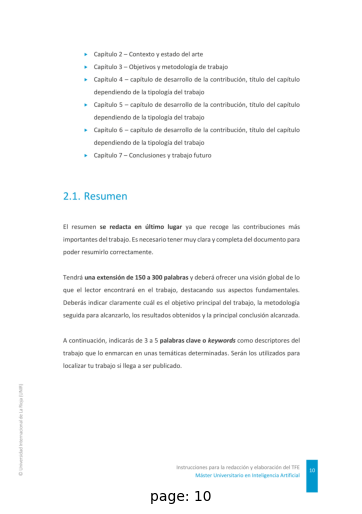

ref:  Capítulo 2 – Contexto y estado del arte  Capítulo 3 – Objetivos y metodología de trabajo  Capítulo 4 – capítulo de desarrollo de la contribución, título del capítulo dependiendo de la tipología del trabajo  Capítulo 5 – capítulo de desarrollo de la contribución, título del capítulo dependiendo de la tipología del trabajo  Capítulo 6 – capítulo de desarrollo de la contribución, título del capítulo dependiendo de la tipología del trabajo  Capítulo 7 – Conclusiones y trabajo futuro  2.1. Resumen  El resumen se redacta en último lugar ya que recoge las contribuciones más importantes del trabajo. Es necesario tener muy clara y completa del documento para poder resumirlo correctamente.  Tendrá una extensión de 150 a 300 palabras y deberá ofrecer una visión global de lo que el lector encontrará en el trabajo, destacando sus aspectos fundamentales. Deberás indicar claramente cuál es el objetivo principal del trabajo, la metodología seguida para alcanzarlo, los resultados obtenidos 

In [11]:


results = []

for pdf_file in os.listdir(PDF_FOLDER):
    if not pdf_file.lower().endswith('.pdf'):
        continue
    pdf_path = os.path.join(PDF_FOLDER, pdf_file)
    images = pdf_to_images(pdf_path)
    
    for i, img in enumerate(images):
        if i == 10:
            break
        page_num = i+1
        ref = pdf_extract_text(pdf_path, page_num=page_num)
        show_page(img, f"page: {page_num}")
        print(f"ref: {ref}")
        
        # Convert PIL image to numpy array
        image_array = np.array(img)
        # EasyOCR
        easy_text = ocr_easyocr(img, image_array)
        print(f"easy_text: {easy_text}")
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'EasyOCR', 'Prediction': easy_text, **evaluate_text(ref, easy_text)})
        
        # TrOCR
        doctr_text = ocr_doctr(img, image_array)
        print(f"docTR_text: {doctr_text}")
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'docTR', 'Prediction': doctr_text, **evaluate_text(ref, doctr_text)})
        
        # PaddleOCR
        paddle_text = ocr_paddle(img, image_array)
        print(f"paddle_text: {paddle_text}")
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'PaddleOCR', 'Prediction': paddle_text, **evaluate_text(ref, paddle_text)})
        

## 5 Save and Analyze Results

Benchmark results saved!
                WER       CER
Model                        
EasyOCR    0.113012  0.056827
PaddleOCR  0.091687  0.078511
doctr      0.195068  0.065045


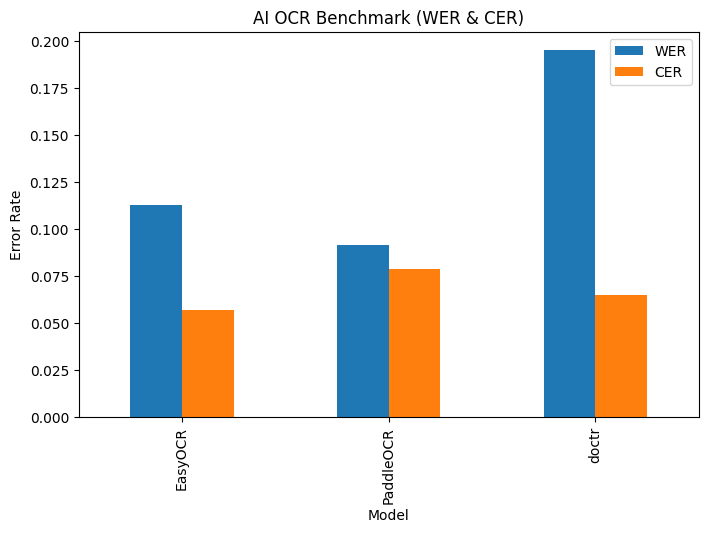

In [12]:
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(OUTPUT_FOLDER, 'ai_ocr_benchmark_results.csv'), index=False)
print('Benchmark results saved!')

# Summary by model
summary = df_results.groupby('Model')[['WER', 'CER']].mean()
print(summary)

# Plot
summary.plot(kind='bar', figsize=(8,5), title='AI OCR Benchmark (WER & CER)')
plt.ylabel('Error Rate')
plt.show()

### How to read this chart:
- CER (Character Error Rate) focus on raw transcription quality
- WER (Word Error Rate) penalizes incorrect tokenization or missing spaces
- CER and WER are error metrics, which means:
    - Higher values = worse performance
    - Lower values = better accuracy

### Compared solutions
| Model                  | Type                         | Components                   | Key Strengths                                              | Why It Matters                                           |
| :--------------------- | :--------------------------- | :--------------------------- | :--------------------------------------------------------- | :------------------------------------------------------- |
| **EasyOCR**            | End-to-end (det + rec)       | DB + CRNN/Transformer        | Lightweight, easy to run, multilingual                     | Serves as *baseline neuronal* (fast & reproducible).     |
| **PaddleOCR (PP-OCR)** | End-to-end (det + rec + cls) | DB + SRN/CRNN                | Strong multilingual support, configurable pipeline         | Industrial reference; widely benchmarked.                |
| **DocTR**              | End-to-end (det + rec)       | DB/LinkNet + CRNN/SAR/VitSTR | Research-oriented, clean API, high-level structured output | Represents the latest *PyTorch*-based academic approach. |


These cover the three major open-source paradigms for deep OCR:

EasyOCR: compact CRNN-based recognizer.

PaddleOCR: large industrial model (PP-OCR family).

DocTR: modular research library from Mindee, built for experimentation.

Together they already let you analyse:

accuracy (CER/WER),

inference latency,

model architecture trade-offs.